# A Basic Prototype of Item2Vec and Customer2Vec Models

This notebook demostrates how word2vec and doc2vec models can be used to analyze customer behavior and compute product and customer embeddings.

We focus on a very basic scenario where customer event histories are generated using a simple Markov chain. We demonstrate that word2vec and doc2vec models capture sequential event patterns.

In [430]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
import random

from gensim.models import Word2Vec
from gensim.models.doc2vec import LabeledSentence, TaggedDocument, Doc2Vec
from sklearn.decomposition import TruncatedSVD

# Step 1: Define Shopper Models and Generate Data

We consider a toy model of an online apparel store that sells two categories of products, hats and dresses. Each category is represented by two products, so we have 4 products in total, 2 hats and 2 dresses. We assume two classes of customers:
* Category shoppers come to buy either a hat or a dress. They tend to browse within one category but rarely switch between categories.
* Look shoppers come to buy both a hat and a dress. They tend to frequently jump between the categories.

Each of these two classes of shoppers is specified using a stochastic transition matrix. 

In [302]:
#
# Shopper transition matrices
#

# Category shopper
transition_matrix_a = np.array([
# Hat 1 | Hat 2 | Dress 1 | Dress 2 
  [0.1,    0.9,    0.0,      0.0],      # Hat 1 
  [0.8,    0.1,    0.1,      0.0],      # Hat 2
  [0.0,    0.0,    0.1,      0.9],      # Dress 1
  [0.1,    0.0,    0.8,      0.1]       # Dress 2
])

# Look shooper 
transition_matrix_b = np.array([
# Hat 1 | Hat 2 | Dress 1 | Dress 2 
  [0.1,    0.9,    0.0,      0.0],      # Hat 1 
  [0.4,    0.1,    0.5,      0.0],      # Hat 2
  [0.0,    0.0,    0.1,      0.9],      # Dress 1
  [0.5,    0.0,    0.4,      0.1]       # Dress 2
])

#
# Stationary distribution over products
#
def stationary_distribution(transition_matrix):
    P = np.transpose(transition_matrix) - np.identity(transition_matrix.shape[0])
    A = np.append(P, np.ones((1, P.shape[0])), axis=0)
    b = np.transpose(np.append(np.zeros(P.shape[0]), [1]))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

print(stationary_distribution(transition_matrix_a))
print(stationary_distribution(transition_matrix_b))

[0.25 0.25 0.25 0.25]
[0.25 0.25 0.25 0.25]


In [410]:
#
# Sample histories generators
#
product_names = {0: 'Hat_1', 1: 'Hat_2', 2: 'Dress_1', 3: 'Dress_2'}
def history_to_tokens(history):
    return list(map(lambda x: product_names[x], history))

def generate_user_history(transition_matrix, n_steps = 20):
    n_products = transition_matrix.shape[0]
    walk = np.random.randint(0, n_products, 1).tolist()
    for i in range(n_steps - 1):
        new_state = np.random.choice(n_products, 1, p=transition_matrix[walk[-1]])[0]
        walk.append(new_state)
    return walk

def generate_histories(transition_matrix, n_steps = 50, n_samples = 10000):
    return [generate_user_history(transition_matrix, n_steps) for i in range(n_samples)]

history_a = generate_histories(transition_matrix_a)
history_b = generate_histories(transition_matrix_b)

all_histories = history_a + history_b
history_a_idx = range(len(history_a))
history_b_idx = range(len(history_a), len(all_histories))

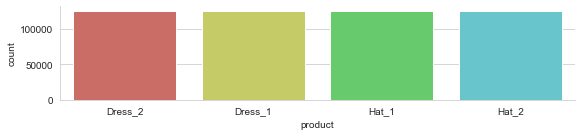

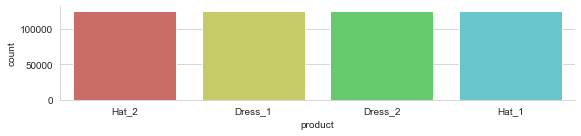

In [470]:
def plot_histogram(history):
    flat_history = np.ravel(np.array(history))
    g = sns.catplot(x='product',
            data=pd.DataFrame(history_to_tokens(flat_history), columns=['product']),
            palette=sns.color_palette("hls", 6),
            kind="count", height=2, aspect=4.0);
    
plot_histogram(history_a)
plot_histogram(history_b)

Both the stationary distributions and histograms of the generated histories confirm that all products have the same frequences. 

# Step 2: Create Product Embeddings Using Word2Vec

Our next step is to fit the word2vec model and examine product embeddings.

In [412]:
emdedding_size = 4
model = Word2Vec(list(map(lambda h: history_to_tokens(h), all_histories)), 
                 window=4, 
                 size=emdedding_size)

In [455]:
# 
# Product embebeddigns
#
word_vectors = model.wv
vocab = list(model.wv.vocab.keys())
product2vec_dict = {arg: model.wv[arg] for arg in vocab}
embeddings = pd.DataFrame(product2vec_dict).T.values
embeddings, vocab

(array([[-0.9728567 , -1.5242368 , -1.5636246 ,  2.6541698 ],
        [-0.50641626, -3.0554023 , -0.5173867 ,  1.6513214 ],
        [ 1.8003583 ,  2.1053102 ,  0.44778004, -1.9983951 ],
        [ 1.1133893 ,  2.1465724 ,  1.9411883 , -1.4789609 ]],
       dtype=float32), ['Dress_2', 'Dress_1', 'Hat_1', 'Hat_2'])

We can see that embeddings within categories are similar, meanwhile two categories are well separated.

# Step 3: Create Embeddings Using Doc2Vec and Visualize the Semantic Space

The last step is to create customer embeddigns using Doc2Vec, project it onto a two-dimensional plane using SVD, and visualize the result to confirm that two classes of customers are separated. 

In [414]:
documents = [ TaggedDocument(words=history_to_tokens(h), tags=[i]) for i, h in enumerate(all_histories) ]
doc_model = Doc2Vec(documents, vector_size = 4, window = 4, workers = 4, alpha = 0.020, epochs = 500)

In [456]:
#
# We project and visualize a balanced subsample of customers to make sure the plot is readable.
#
samples_per_class = 2000
history_sample_idx = random.sample(history_a_idx, samples_per_class) + random.sample(history_b_idx, samples_per_class)
history_true_class = ['A']*samples_per_class + ['B']*samples_per_class
embeddings_sample = [doc_model.docvecs[i] for i in history_sample_idx]

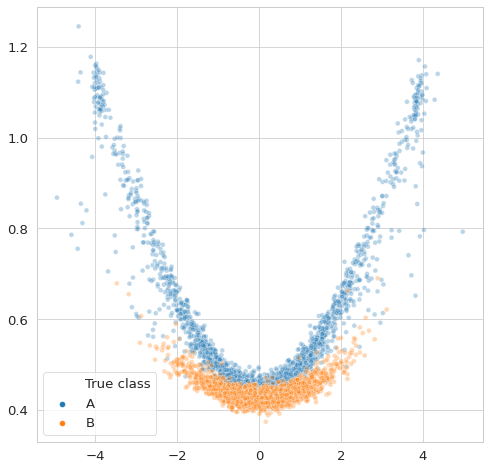

In [507]:
svd = TruncatedSVD(n_components=2)
embeddings_reduced = svd.fit_transform(embeddings_sample)

df_semantic_user = pd.DataFrame({
    'True class': history_true_class,
    'svd_2d_one': embeddings_reduced[:, 0],
    'svd_2d_two': embeddings_reduced[:, 1]
})

#
# Visualize the semantic space
#
plt.figure(figsize=(8, 8)) 
sns.set_context("paper", font_scale = 1.5)
sns.set_style({'font.family':'Candara', 'font.serif':['Candara']})
g = sns.scatterplot(
    x="svd_2d_one", y="svd_2d_two",
    hue='True class',
    palette=sns.color_palette(['#1f77b4', '#ff7f0e']),
    data=df_semantic_user,
    legend="full",
    alpha=0.3
)
g.set(xlabel=None)
g.set(ylabel=None)
plt.show()

In [508]:
#
# Save the figure
#
g.figure.savefig("user-space-svd.pdf")